# | P8 - Conception d'une voiture autonome

## Contexte

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

<img src="https://user.oc-static.com/upload/2019/10/24/15719060749143_image2.png">


En tant qu'ingénieurs IA au sein de l’équipe R&D de cette entreprise. notre équipe est composée d’ingénieurs aux profils variés. Chacun des membres de l’équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur. 

Voici les différentes parties du système :

1. Acquisition des images en temps réel
2. Traitement des images
3. Segmentation des images - <b>Partie nous concernant</b>
4. Système de décision

Notre rôle est de concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Lors d’une première phase de cadrage, nous avons récolté les avis des différentes parties prenante de l'équipe :

La partie en charge du traitement des images (2) :

- Le jeu de données que utilisé est disponible à ce lien https://www.cityscapes-dataset.com/dataset-overview/ (images segmentées et annotées de caméras embarquées). On a uniquement besoin des 8 catégories principales (et non pas des 32 sous-catégories)
- Les images en entrée peuvent changer. Le système d’acquisition n’est pas stable. 
- Le volume de données sera vite important.


La partie en charge du système de décision (4)

- Souhaite une API simple à utiliser.
- L’API prend en entrée l’identifiant d’une image et renvoie la segmentation de l’image de l’algo, et de l’image réelle.

## Approche Méthodologique

Nos objectifs sont les points suivants :

- entraîner et déployer un modèle de segmentation des images sur les 8 catégories principales en utilisant Azure Machine Learning. Keras étant le framework de travail commun à toute l’équipe.
- déploiement une API Flask grâce au service Azure qui sera utilisée.

Pour cela nous détaillons le plan d'action suivant :
1. Observation des données, qui nous permettra de nous approprier les données du projet,
2. Préparation et Augmentation de données, qui nous permettra de générer nos données d'entrainement,
3. Construction et entrainement des modèles,
4. Déploiement sur le service cloud de Microsoft Azure.


# Observation des données

Par la suite nous observerons la répartition de nos données ainsi que les fichiers images contenues dans les différents répertoires.

In [1]:
from functions import *

print('* First Directory "gtFine_trainvaltest" :')
for dir_ in os.listdir(path_gtFine_trainvaltest):
    print(f'-> Directory "{dir_}" ({len(os.listdir(path_gtFine_trainvaltest+dir_))} cities):')
    [print(f"    |__{city}") for city in os.listdir(path_gtFine_trainvaltest+dir_)]

print()
print('* Second Directory "leftImg8bit_trainvaltest" :')
for dir_ in os.listdir(path_leftImg8bit_trainvaltes):
    print(f'-> Directory "{dir_}" ({len(os.listdir(path_leftImg8bit_trainvaltes+dir_))} cities):')
    [print(f"    |__{city}") for city in os.listdir(path_leftImg8bit_trainvaltes+dir_)]

* First Directory "gtFine_trainvaltest" :
-> Directory "test" (6 cities):
    |__bielefeld
    |__leverkusen
    |__bonn
    |__berlin
    |__mainz
    |__munich
-> Directory "train" (18 cities):
    |__zurich
    |__strasbourg
    |__weimar
    |__aachen
    |__tubingen
    |__jena
    |__bochum
    |__darmstadt
    |__dusseldorf
    |__hamburg
    |__cologne
    |__monchengladbach
    |__krefeld
    |__ulm
    |__hanover
    |__stuttgart
    |__erfurt
    |__bremen
-> Directory "val" (3 cities):
    |__munster
    |__lindau
    |__frankfurt

* Second Directory "leftImg8bit_trainvaltest" :
-> Directory "test" (6 cities):
    |__bielefeld
    |__leverkusen
    |__bonn
    |__berlin
    |__mainz
    |__munich
-> Directory "train" (18 cities):
    |__zurich
    |__strasbourg
    |__weimar
    |__aachen
    |__tubingen
    |__jena
    |__bochum
    |__darmstadt
    |__dusseldorf
    |__hamburg
    |__cologne
    |__monchengladbach
    |__krefeld
    |__ulm
    |__hanover
    |__stuttgart


Les données immages sont répartie en deux gros dossier : 
* Le premier : gtFine_trainvaltes, qui contient 3 dossiers train, test et val. Chaqun de ces dossier contient un ensemble de fichiers pnj répartie en fonction des villes des prises de capture :
    - Fine_color.png : fichier photo de segmentation 1,
    - Fine_instanceIds.png : fichier photo de segmentation 2,
    - Fine_labelIds.png : fichier photo de segmentation 3,
    - Fine_polygons.json : fichier json contenant des méta-données.


* Le second : leftImg8bit_trainvaltest, également segmenté en 3 dossiers train, test et val mais aussi en fonction des mêmes villes listés précédement. Chaque sous-dossier ville contient les images originel de taille 


<b>Observons à présent ces différents fichiers</b>

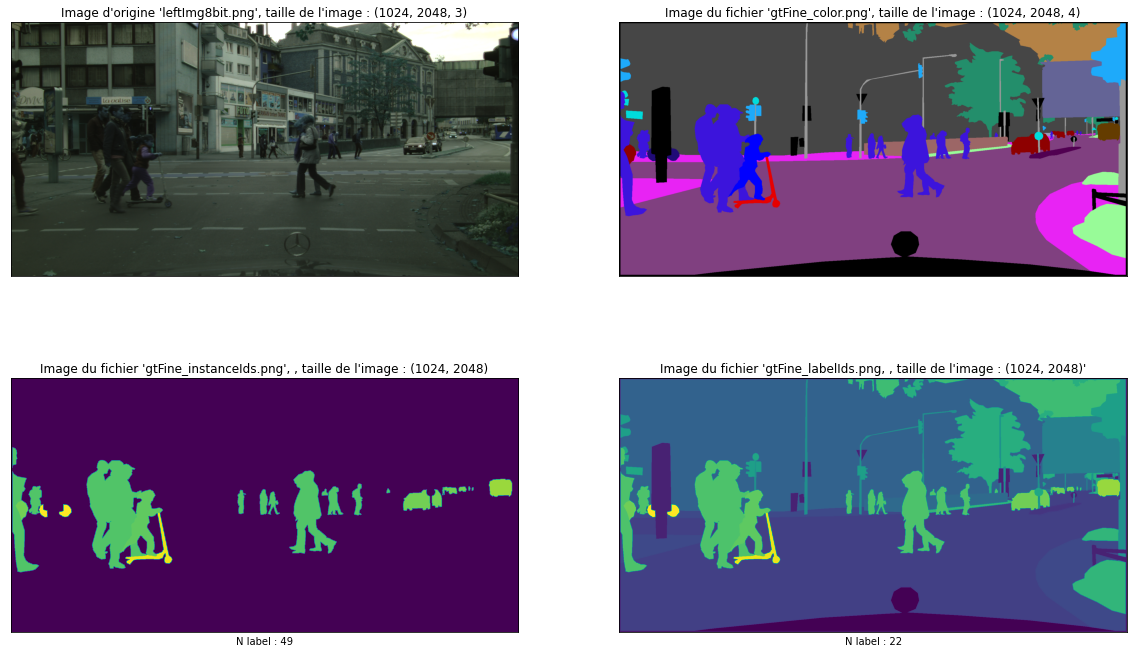

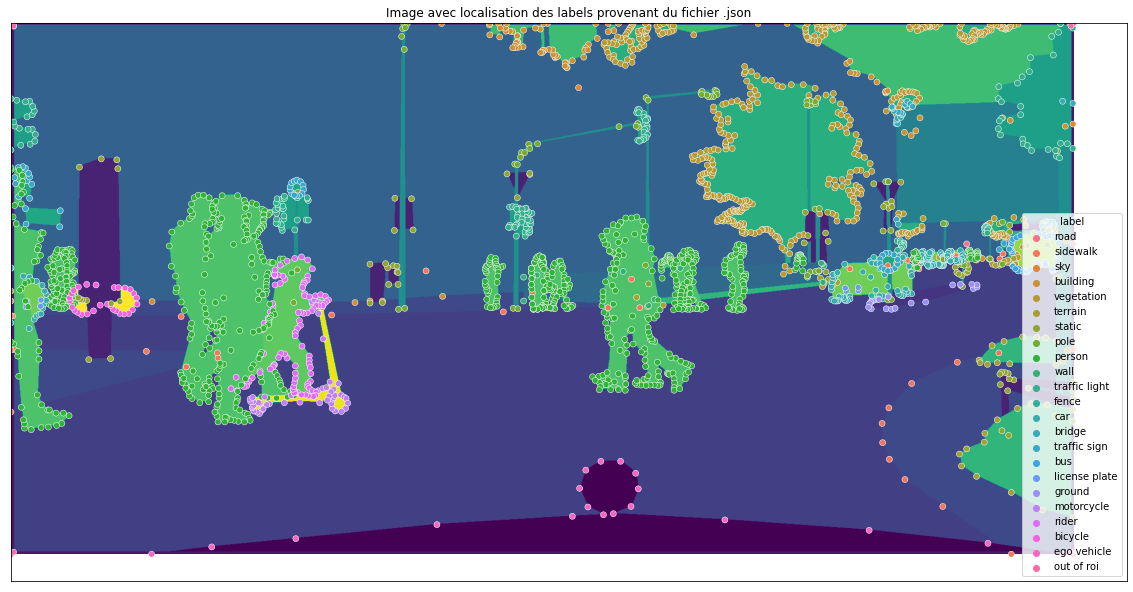

Elément contenu dans le fichier csv : dict_keys(['imgHeight', 'imgWidth', 'objects'])

Liste des Labels du fichier photo :  Counter({'person': 21, 'static': 13, 'pole': 13, 'traffic light': 10, 'vegetation': 8, 'car': 8, 'traffic sign': 7, 'sidewalk': 5, 'terrain': 4, 'license plate': 3, 'road': 1, 'sky': 1, 'building': 1, 'wall': 1, 'fence': 1, 'bridge': 1, 'bus': 1, 'ground': 1, 'motorcycle': 1, 'rider': 1, 'bicycle': 1, 'ego vehicle': 1, 'out of roi': 1})


In [2]:
data_ = show_img()

print(f'Elément contenu dans le fichier csv : {data_[0].keys()}')
print()
print('Liste des Labels du fichier photo : ', count([objet['label'] for objet in data_[0]['objects']]))

Après observations, voici les éléments à retenir :

    - fichiers "Fine_color.png" : segmentation en couleur de taille (1024, 2048, 4),
    - Fine_instanceIds.png : segmentation en couleur de taille (1024, 2048) contenant jusqu'à 255 couleurs uniques,
    - Fine_labelIds.png : segmentation en couleur de taille (1024, 2048) contenant jusqu'à 32 couleurs
    - Fine_polygons.json : fichier json contenant des méta-données.

L'ensemble de ces fichiers nous permettent de déterminer quels seront les élément qui serviront àl'entrainement de nos modèles :
- Les photographies d'origine contenu dans le fichier "leftImg8bit_trainvaltest" servira de jeu de données pour nos modèles.
- Les images "gtFine_labelIds.png" serviront de target pour nos modèles

<b> A noter que notre Target doit encore passer de 32 labels à 8 labels pour notre segmentation d'image<b/>

# Data Préparation

## Séléction des données d'entrainement et de validation

Nous l'avons vu précédement, l'ensemble de nos fichiers sont répartis en fonction des villes d'origine des prise de vue.

Par lasuite nous crérons deux répertoirs et un fichier:
- un répertoir "data" : contenant nos données d'entrainement stockés sous forme de fichier .npy,
- un répertoir 'label' : contenant nos labels également sous format .npy,
- un fichier id_.csv : contenant la liste des id de nos images ainsi que les chemins d'accès aux images et labels. 

<b> Par la suite nous procédons à la transformation de nos labels puis au stockage de nos données. </b>

In [30]:
# Move data 
for city in os.listdir(path_leftImg8bit_trainvaltes+'train'):
    for img in os.listdir(path_leftImg8bit_trainvaltes+'train/'+city):
        shutil.move(path_leftImg8bit_trainvaltes+'train/'+city+'/'+img, './data/'+img)
        
for city in os.listdir(path_leftImg8bit_trainvaltes+'/val'):
    for img in os.listdir(path_leftImg8bit_trainvaltes+'/val/'+city):
        shutil.move(path_leftImg8bit_trainvaltes+'/val/'+city+'/'+img, './data/'+img)
        
# Move label
for city in os.listdir(path_gtFine_trainvaltest+'train'):
    for img in os.listdir(path_gtFine_trainvaltest+'train/'+city):
         if 'labelIds.png' in img :
            shutil.move(path_gtFine_trainvaltest+'train/'+city+'/'+img, './label/'+img)
        
for city in os.listdir(path_gtFine_trainvaltest+'/val'):
    for img in os.listdir(path_gtFine_trainvaltest+'/val/'+city):
        if 'labelIds.png' in img :
            shutil.move(path_gtFine_trainvaltest+'/val/'+city+'/'+img, './label/'+img)

In [4]:
df = np.zeros((len(os.listdir('label')), 4))
df = pd.DataFrame(df, columns=['id', 'city', 'img', 'label'])
df.id = sorted([id_.split('leftImg8bit.png')[0] for id_ in os.listdir('data')])
df.city = sorted([id_.split('_')[0] for id_ in os.listdir('data')])
df.img = sorted(os.listdir('data'))
df.label = sorted(os.listdir('label'))
df

,id,city,img,label
0,aachen_000000_000019_,aachen,aachen_000000_000019_leftImg8bit.png,aachen_000000_000019_gtFine_labelIds.png
1,aachen_000001_000019_,aachen,aachen_000001_000019_leftImg8bit.png,aachen_000001_000019_gtFine_labelIds.png
2,aachen_000002_000019_,aachen,aachen_000002_000019_leftImg8bit.png,aachen_000002_000019_gtFine_labelIds.png
3,aachen_000003_000019_,aachen,aachen_000003_000019_leftImg8bit.png,aachen_000003_000019_gtFine_labelIds.png
4,aachen_000004_000019_,aachen,aachen_000004_000019_leftImg8bit.png,aachen_000004_000019_gtFine_labelIds.png
...,...,...,...,...
3470,zurich_000117_000019_,zurich,zurich_000117_000019_leftImg8bit.png,zurich_000117_000019_gtFine_labelIds.png
3471,zurich_000118_000019_,zurich,zurich_000118_000019_leftImg8bit.png,zurich_000118_000019_gtFine_labelIds.png
3472,zurich_000119_000019_,zurich,zurich_000119_000019_leftImg8bit.png,zurich_000119_000019_gtFine_labelIds.png
3473,zurich_000120_000019_,zurich,zurich_000120_000019_leftImg8bit.png,zurich_000120_000019_gtFine_labelIds.png


La modification de nos segments prends en compte les labels et leurs class d'apartenance listé ci dessous :

- 'void': [0, 1, 2, 3, 4, 5, 6],
- 'flat': [7, 8, 9, 10],
- 'construction': [11, 12, 13, 14, 15, 16],
- 'object': [17, 18, 19, 20],
- 'nature': [21, 22],
- 'sky': [23],
- 'human': [24, 25],
- 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]

In [69]:
%%time
def chage_label(x):
    path = x
    x = cv2.imread('label/'+x,0)
    x = (np.isin(x, [0, 1, 2, 3, 4, 5, 6])*1\
    +np.isin(x, [7, 8, 9, 10])*2\
    +np.isin(x, [11, 12, 13, 14, 15, 16])*3\
    +np.isin(x, [17, 18, 19, 20])*4\
    +np.isin(x, [21, 22])*5\
    +np.isin(x, [23])*6\
    +np.isin(x, [24, 25])*7\
    +np.isin(x, [26, 27, 28, 29, 30, 31, 32, 33, -1])*8) - 1
    cv2.imwrite('label/'+path, x)
    
_ = df.label.apply(chage_label)
df.to_csv('data.csv')

CPU times: user 4min 18s, sys: 31.1 s, total: 4min 49s
Wall time: 4min 51s


0       None
1       None
2       None
3       None
4       None
        ... 
3470    None
3471    None
3472    None
3473    None
3474    None
Name: label, Length: 3475, dtype: object

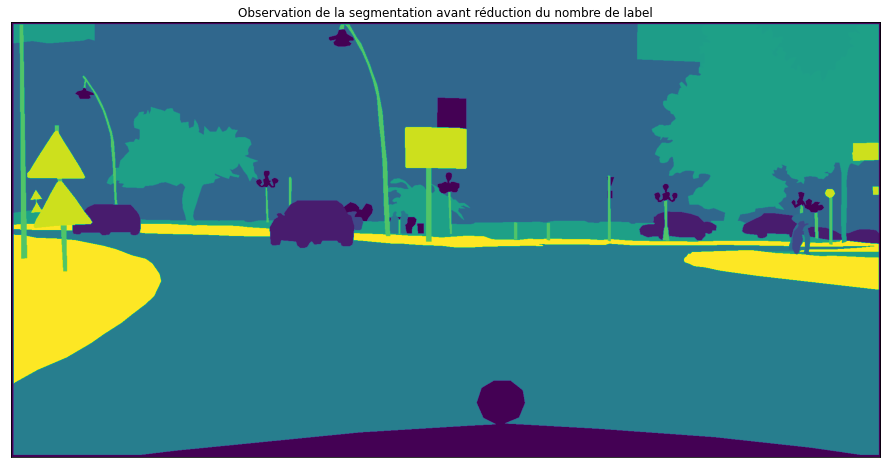

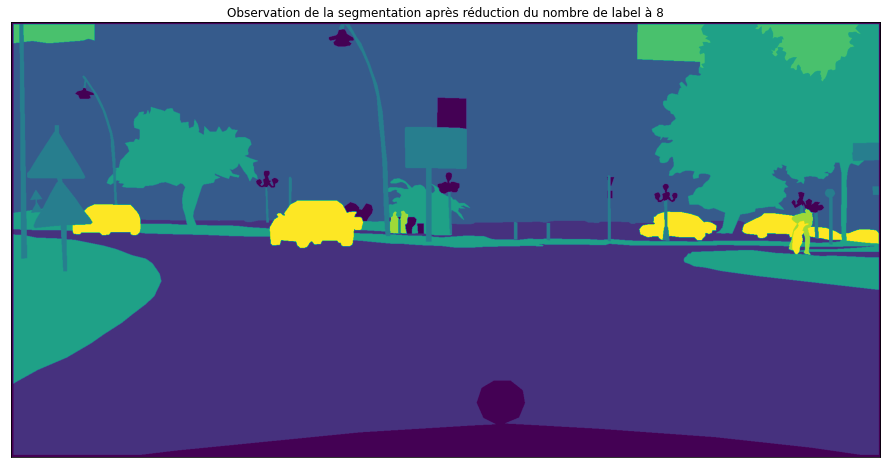

In [90]:
plt.figure(figsize=(20,8))
plt.xticks([])
plt.yticks([])
plt.title('Observation de la segmentation avant réduction du nombre de label')
plt.imshow(cv2.imread('P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png',0))
plt.show()


plt.figure(figsize=(20,8))
plt.xticks([])
plt.yticks([])
plt.title('Observation de la segmentation après réduction du nombre de label à 8')
plt.imshow(cv2.imread('label/'+df.label[0],0))
plt.show()

 ## Data augmentation

In [29]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2

img = cv2.imread('data/'+df.img[0],0)
seg = cv2.imread('label/'+df.label[0],0)


def augment_seg(img, seg):

    aug_det = seq.to_deterministic() 
    image_aug = aug_det.augment_image(img)

    segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg)+1, shape=img.shape)
    
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr_int()

    return image_aug , segmap_aug

* <b>Horizontally flip 50% of the images</b>

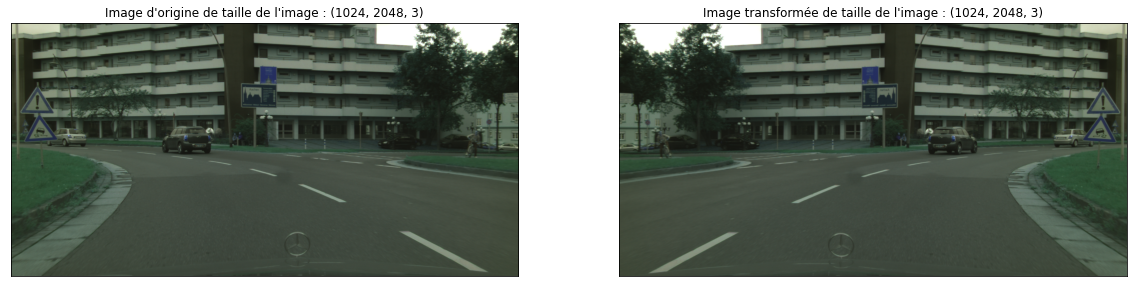

In [11]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)    
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
])

show_2img(img, augment_seg(img, seg)[0])

* <b> Augmentation de la nettetée </b>

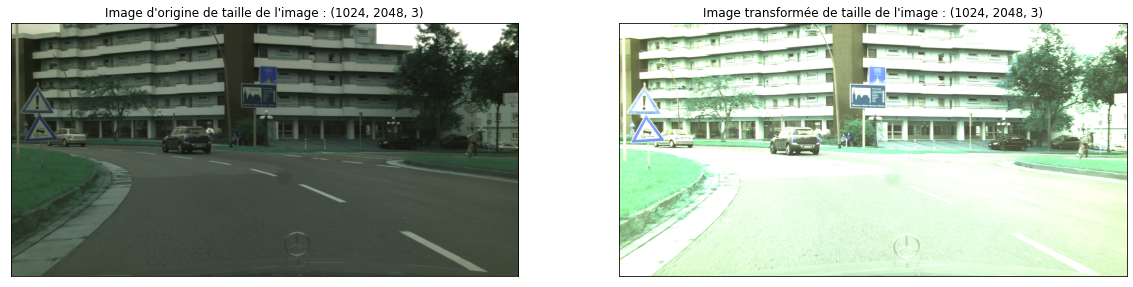

In [12]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)    
    iaa.Sharpen(alpha=(1.0, 1.0), lightness=(6.75, 2.0))
])

show_2img(img, augment_seg(img, seg)[0])

* <b> Augmentation du contrast </b>

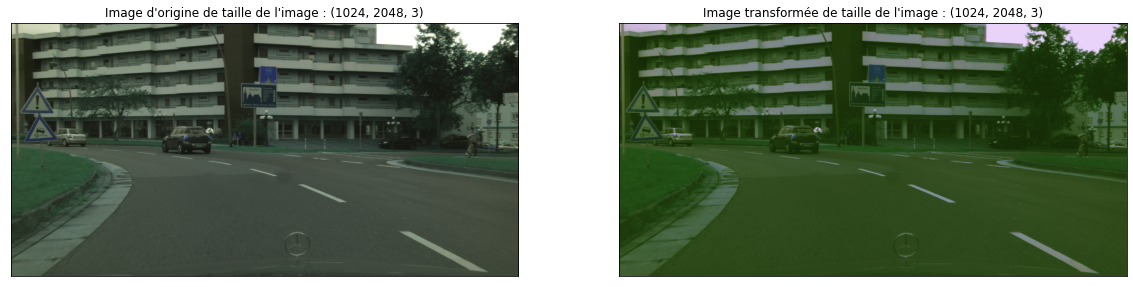

In [13]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)    
    iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6), per_channel=True)
])

show_2img(img, augment_seg(img, seg)[0])

* <b> Transformation aléatoire </b>

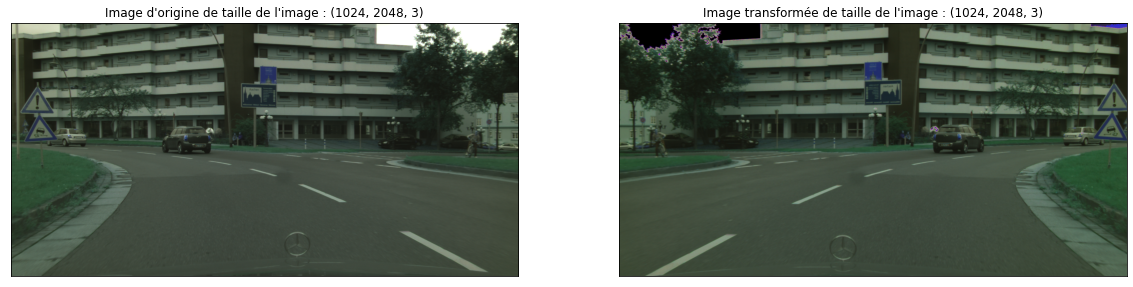

In [14]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)    
    iaa.RandAugment(n=2, m=9)
])

show_2img(img, augment_seg(img, seg)[0])

## Générateur de données

Par la suite nous créons dans le fichier nomé 'class_.py' notre générateur de données qui servira à l'entrainement de nos modèles. 

Ce générateur intègre également notre composante de d'augmentation de données.

In [4]:
%%writefile class_.py
import random
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from cv2 import imread
from tensorflow.keras.utils import Sequence, to_categorical

# Class générent les données d'entrainement et de validation
class MY_Generator(Sequence):
    def __init__(self, image_filenames, batch_size, augmented=False):
        """
        image_filenames : (array-list of str) des ids images contenu dans le répertoir data & label
        
        batch_size : (int) taille des lots d'entrainement 
        
        augmented : (boolean) augmentation aléatoir des données d'entrainement
        """
        
        self.image_filenames = image_filenames 
        self.batch_size = batch_size
        self.augmented = augmented
        self.seq = iaa.Sequential([
            iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)    
        ])
    
    # Méthode permettant de générer une augmentation de données
    def augment_data(self, img, seg):
        """
        img : array image d'origine de taille (n,m)
        seg : array image des label de taille (n,m)
        """
        aug_det = self.seq.to_deterministic() 
        image_aug = aug_det.augment_image(img)

        segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg)+1, shape=img.shape)

        segmap_aug = aug_det.augment_segmentation_maps(segmap)
        segmap_aug = segmap_aug.get_arr_int()
        return image_aug, segmap_aug
    
    # Méthode permettant de lire les fichier des répertoir 'data' ou 'label'
    def read(self, file_name, data):
        """
        file_name : (str) nom des fichiers à lire,
        data : (str) type de données 'data' pour lire les fichiers du répertoir data, 'label' pour lire 
        les fichiers du répertoir 'label'.
        """
        if data == 'label':
            return imread(f'./label/{file_name}gtFine_labelIds.png', 0)
        elif data == 'data':
            return imread(f'./data/{file_name}leftImg8bit.png', 0)

    # Retourne le nombre de lot à envoyer au modèle
    def __len__(self):
        return int(np.ceil(len(self.image_filenames)/float(self.batch_size)))


    #Fonction permettant de charger le lot de données d'entrainement
    def __getitem__(self, idx):
        # index des images à prendre en considération
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Si l'option Data Augmentation est activée, la méthode augment_data est appliquée
        if self.augmented:
            augmented_data = np.array([self.augment_data(self.read(file_name, 'data'), 
                                                         self.read(file_name, 'label')) 
                                       for file_name in batch_x])

            X = np.concatenate((np.array([self.read(file_name, 'data') for file_name in batch_x]),
                                   augmented_data[:,0]),axis=0)
            
            y =  to_categorical(np.concatenate((np.array([self.read(file_name, 'label') 
                                                          for file_name in batch_x]), 
                                                augmented_data[:,1]), axis=0))
            
            # index aléatoire des images d'origine et augmentées
            index = list(range(len(X)))
            random.shuffle(index)
            return X[index[:len(batch_x)]], y[index[:len(batch_x)]]
        
        # Sinon, le lot de données X et y sont importée des répertoir 'data' et 'label'
        else:
            X = np.array([self.read(file_name, 'data') for file_name in batch_x])
            y = to_categorical([np.array(self.read(file_name, 'label')) for file_name in batch_x])
            return X, y 

Writing tesr.py
